## Spatial Transformation

In [2]:
from PIL import Image, ImageOps, ImageDraw
from scipy import ndimage
import random   
import numpy as np

 This is a notebook meant to play around and research common spatial tranfsormation operations applied to video-based dataset, such as those of egocentric hand gesture recognition

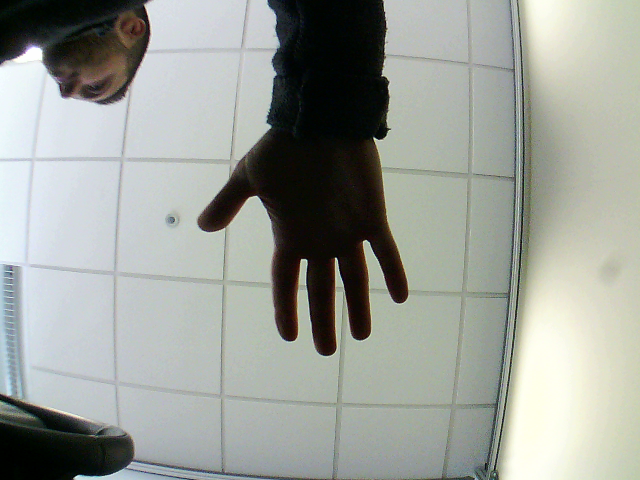

In [3]:
img = Image.open(r"D:\\School\\Lab\\Compact-Gesture-Transformer-Code\\data\\Briareo\\rgb\\train\\011\\g06\\01\\rgb\\040_rgb.png")
display(img)

### 1. Multiscale Random Cropping

Multiscale random cropping means you randomly a select a smaller portion of the image  with varying width and height. For example, I can randomly crop a small and random h x w portion of the original image, and use that instead of the original image.

I think this has potential potential and should be applied in the realm of egocentric hand gesture beacuse it can simulate the differing depth  to the camera when I perform an action. For example, cropping the hand can make it seem like the object is closer to the camera than in reality, simulating depth

In [166]:
def multiscale_random_cropping(img, scales=[0.3, 0.6, 0.9]):
    # Iterate through the crops
    # Calculate width and height of image
    # Calculate the possible starting point using randomization
    # Define a box to do cropping
    # Crop the images and add to arr
    
    w, h = img.size
    images = []
    
    for scale in scales:
        crop_width, crop_height = w*scale, h*scale
        x = random.randint(0, w - crop_width)
        y = random.randint(0, h - crop_height)
        new_image = img.crop((x, y, x + crop_width, y + crop_height))
        new_image = new_image.resize((224, 224))
        images.append(new_image)
        
    
    return images
    

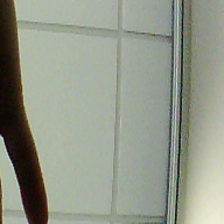

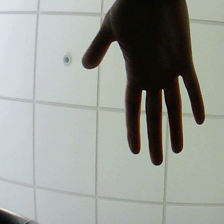

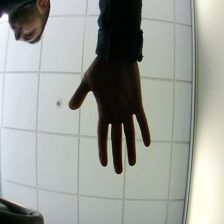

In [ ]:
cropped_images = multiscale_random_cropping(img)
for image in cropped_images:
    display(image)

One notable disadvantage is that I can get an image crop that has nothing to do with my main tasks. For example, I can accidentally crop the background rather than the hand itself

## 2. Elastic Deformation (Form of Image Warping)

Started first as a data augmentation technique for MNIST, but people started applying it for non-rigid objects such as human bodies and hands. 

Papers applying the technique:
- Ge, L., Liang, H., Yuan, J., & Thalmann, D. (2017). "Robust 3D Hand Pose Estimation in Single Depth Images from Multi-view CNNs."
- Garcia-Hernando, G., et al. (2018). "First-Person Hand Action Benchmark with RGB-D Videos and Ground Truth 3D Pose." CVPR 2018.


"Hand gesture data is often scarce. The authors noted that hands have high "degrees of freedom" (DOF) and their shape changes significantly based on the user's anatomy." - Gemini

In [168]:
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter, map_coordinates

def apply_elastic_deformation(image, alpha=1000, sigma=30):
    """
    Applies a non-rigid elastic warp to a Pillow image.
    
    Args:
        image: PIL Image object.
        alpha: Scaling factor (intensity of the warp). Higher = more distortion.
        sigma: Smoothing factor (Gaussian standard deviation). 
               Higher = smoother, more organic warps. Lower = "crunchy" distortion.
    """
    # 1. Convert Pillow Image to NumPy array
    img_array = np.array(image)
    shape = img_array.shape
    
    # 2. Generate random displacement fields
    # We create noise between -1 and 1
    dx = np.random.rand(shape[0], shape[1]) * 2 - 1
    dy = np.random.rand(shape[0], shape[1]) * 2 - 1
    
    # 3. Smooth the noise using a Gaussian filter
    # This is the "Elastic" part—it ensures neighboring pixels move similarly
    dx = gaussian_filter(dx, sigma) * alpha
    dy = gaussian_filter(dy, sigma) * alpha
    
    # 4. Construct the coordinate grid
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    
    # Add the displacement to the grid
    indices = (
        np.reshape(y + dy, (-1, 1)), 
        np.reshape(x + dx, (-1, 1))
    )
    
    # 5. Map the original pixels to the new indices (Interpolation)
    distorted_channels = []
    
    # Handle RGB images by processing each channel
    if len(shape) == 3:
        for i in range(shape[2]):
            channel = map_coordinates(img_array[:, :, i], indices, order=1, mode='reflect')
            distorted_channels.append(channel.reshape(shape[0], shape[1]))
        distorted_img = np.stack(distorted_channels, axis=2)
    else:
        # Grayscale
        distorted_img = map_coordinates(img_array, indices, order=1, mode='reflect').reshape(shape)
    
    # 6. Convert back to Pillow Image
    return Image.fromarray(distorted_img.astype(np.uint8))

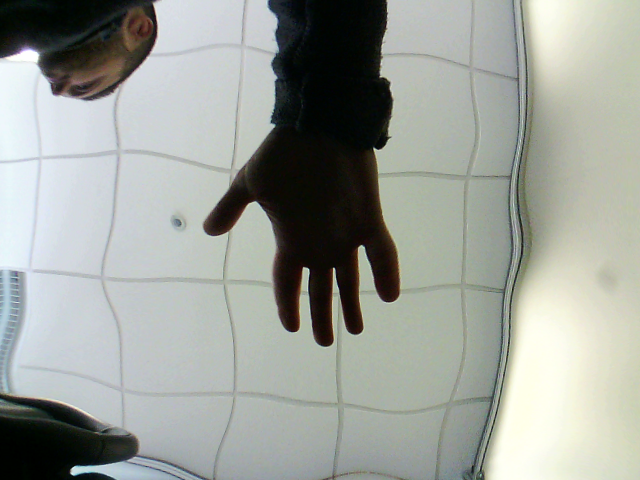

In [169]:
display(apply_elastic_deformation(img))

## 3. Restricted Rotation

Perform rotation to simulate head tilt, but it should be restricted as to not confused a gesture for another gesture, such as "swipe up" and "swipe left"

Paper that cited restricted rotation:
- "EgoGesture: A New Dataset and Benchmark for Egocentric Hand Gesture Recognition." IEEE Transactions on Multimedia.

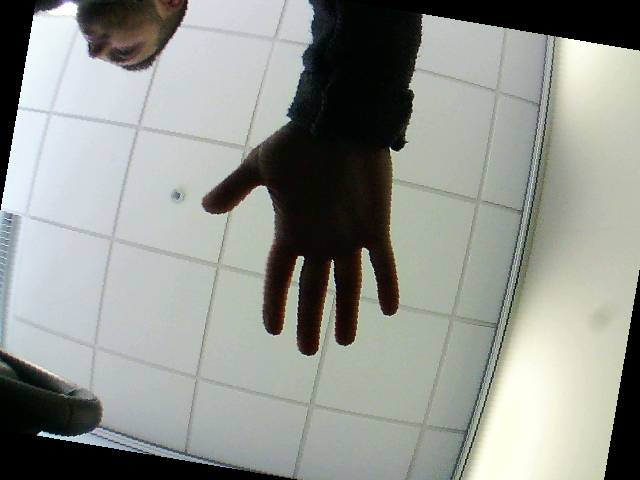

In [170]:
def restricted_rotation(img, rotation_angle):
    rotated_image = img.rotate(rotation_angle, expand=False,)
    return rotated_image

# A good restricted angle was said to be at most 15 degrees
rotation_angle = np.random.uniform(-10, 10)
rotated_image = restricted_rotation(img, rotation_angle)
display(rotated_image)

## 4. Random erasing

Random erasing might make the model robust to occlusions or issues the camera, such as a finger being occluded. This might also make the model more robust for gestures being performed near the edge of the screen

Paper:
- Devineau, G., et al. (2018). "Deep Learning for Hand Gesture Recognition on Skeletal Data." IEEE International Conference on Automatic Face & Gesture Recognition (FG 2018).

In [ ]:
def random_erasing(img):
    w,h = img.size
    # One way to further implement this is by not setting 6 as a fixed hard value
    random_mask_width = random.randint(1, w//6)
    random_mask_height = random.randint(1, h//6)
    
    mask_start_x = w - random_mask_width
    mask_start_y = h - random_mask_height
    
    draw = ImageDraw.Draw(img)
    fill_color = (0, 0, 0)
    draw.rectangle([mask_start_x, mask_start_y, mask_start_x + random_mask_width, mask_start_y + random_mask_height], fill = fill_color)
    
    return img


erased_image = random_erasing(img)
display(erased_image)
    
    

(640, 480)
